# Student Loan Risk with Deep Learning

In [1491]:
# Imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, Nadam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from pathlib import Path

import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


---

## Part 1: Prepare the data to be used on a neural network model

### Step 1: Read the `student-loans.csv` file into a Pandas DataFrame. Review the DataFrame, looking for columns that could eventually define your features and target variables.   

In [1492]:
# Read the csv into a Pandas DataFrame
file_path = "https://static.bc-edx.com/ai/ail-v-1-0/m18/lms/datasets/student-loans.csv"
loans_df = pd.read_csv(file_path)

# Review the DataFrame
display (loans_df.head())
display (loans_df.shape)

,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score,credit_ranking
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


(1599, 12)

In [1493]:
# Review the data types associated with the columns
loans_df.dtypes

payment_history           float64
location_parameter        float64
stem_degree_score         float64
gpa_ranking               float64
alumni_success            float64
study_major_code          float64
time_to_completion        float64
finance_workshop_score    float64
cohort_ranking            float64
total_loan_score          float64
financial_aid_score       float64
credit_ranking              int64
dtype: object

In [1494]:
# Check the credit_ranking value counts
display (loans_df["credit_ranking"].value_counts())
# another way of looking at the feature. not prefered as this does not show the count per class
display (loans_df['credit_ranking'].unique())

credit_ranking
1    855
0    744
Name: count, dtype: int64

array([0, 1], dtype=int64)

### Step 2: Using the preprocessed data, create the features (`X`) and target (`y`) datasets. The target dataset should be defined by the preprocessed DataFrame column “credit_ranking”. The remaining columns should define the features dataset.

In [1495]:
# Define the target set y using the credit_ranking column

y = loans_df['credit_ranking']
# Display a sample of y

np.array(y)[:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [1496]:
# Define features set X by selecting all columns but credit_ranking
X=loans_df.drop(columns=['credit_ranking'])

# Review the features DataFrame
display (X.head())


,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### Step 3: Split the features and target sets into training and testing datasets.


In [1497]:
# Calculating VIF for each feature
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Displaying VIF scores
sorted_vif =  vif.sort_values(by='VIF', ascending=False)
print(sorted_vif)

                   feature          VIF
7   finance_workshop_score  1479.287209
8           cohort_ranking  1070.967685
10     financial_aid_score   124.394866
0          payment_history    74.452265
9         total_loan_score    21.590621
1       location_parameter    17.060026
2        stem_degree_score     9.183495
4           alumni_success     6.554877
6       time_to_completion     6.519699
5         study_major_code     6.442682
3              gpa_ranking     4.662992


In [1498]:
# drop_columns = ['finance_workshop_score','cohort_ranking','financial_aid_score','payment_history','total_loan_score','location_parameter']
drop_columns = ['gpa_ranking','alumni_success','finance_workshop_score','cohort_ranking']
# X = X.drop(columns=drop_columns)

In [1499]:
# Calculating VIF for each feature
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Displaying VIF scores
sorted_vif = vif.sort_values(by='VIF', ascending=False)
print(sorted_vif)

                   feature          VIF
7   finance_workshop_score  1479.287209
8           cohort_ranking  1070.967685
10     financial_aid_score   124.394866
0          payment_history    74.452265
9         total_loan_score    21.590621
1       location_parameter    17.060026
2        stem_degree_score     9.183495
4           alumni_success     6.554877
6       time_to_completion     6.519699
5         study_major_code     6.442682
3              gpa_ranking     4.662992


# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=1)

In [1500]:
# Assume X and y are your features and labels respectively
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=1)  # Split into training and temp (validation + test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=1)  # Split the temp into validation and test


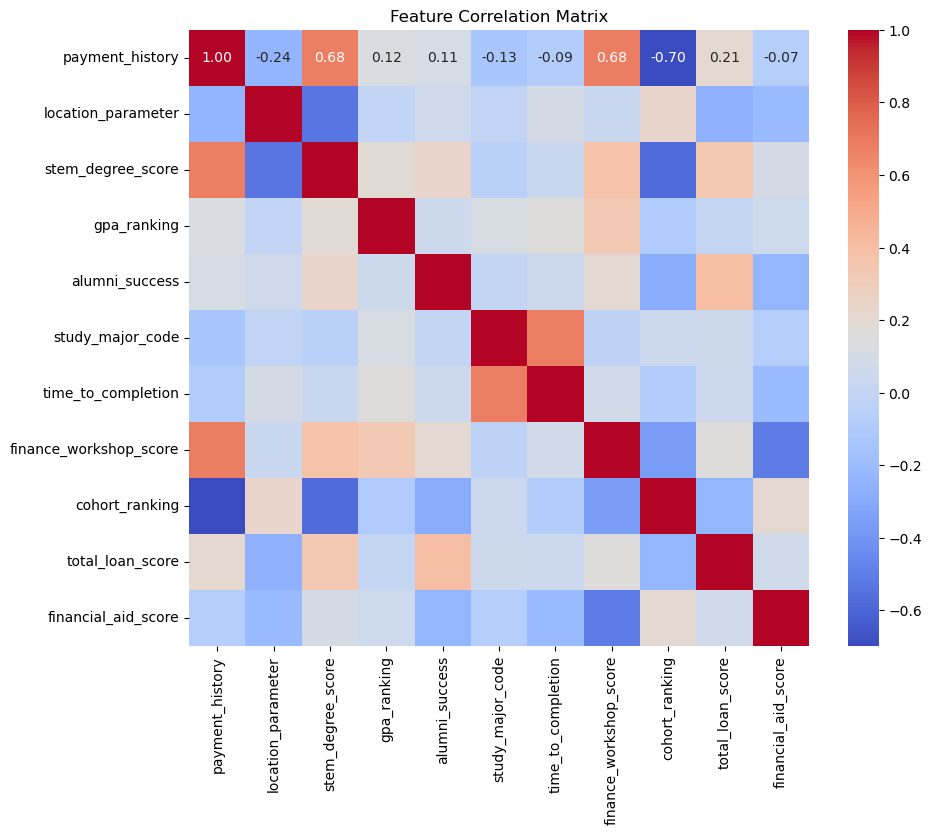

In [1501]:
# Check for high corrilation
correlation_matrix = X_train.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Step 4: Use scikit-learn's `StandardScaler` to scale the features data.

In [1502]:
# Step 1: Create a StandardScaler instance
scaler = StandardScaler()

# Step 2: Fit the scaler to the features training dataset
scaler.fit(X_train)

# Step 3: Transform the features training dataset
X_train_scaled = scaler.transform(X_train)

# Step 4: Transform the features testing dataset
X_test_scaled = scaler.transform(X_test)

# Step 4: Transform the features testing dataset
X_val_scaled = scaler.transform(X_val)


# Optional: Display the first few entries of the scaled features to verify the scaling
# print("Scaled X_train sample:\n", X_train_scaled[:5])
# print("Scaled X_test sample:\n", X_test_scaled[:5])

---

## Part 2 Compile and Evaluate a Model Using a Neural Network

### Step 1: Create a deep neural network by assigning the number of input features, the number of layers, and the number of neurons on each layer using Tensorflow’s Keras.

> **Hint** You can start with a two-layer deep neural network model that uses the `relu` activation function for both layers.


In [1503]:
# Define the the number of inputs (features) to the model
input_nodes  = X_train_scaled.shape[1]
# or 
# input_nodes = len(X.columns)

# Review the number of features
display ("Number of input features:", input_nodes )

'Number of input features:'

11

# Neural Network Configuration Guide

## 1. Define the Number of Hidden Nodes for the First Hidden Layer
For the first hidden layer, a common approach is to start with a number of nodes that is somewhere between the number of input features and the number of output neurons. A typical strategy might be to use a number of nodes that is the mean or the geometric mean of these two numbers, adjusted based on the complexity of the problem or empirical testing.

## 2. Define the Number of Hidden Nodes for the Second Hidden Layer
For the second hidden layer, you might choose to reduce the number of nodes compared to the first hidden layer. This is often done to gradually reduce the dimensionality and to aggregate the features extracted by the first layer. A typical rule might be to halve the number of nodes in each subsequent layer, although the specific number should be tuned based on model performance and overfitting concerns.

## 3. Define the Number of Neurons in the Output Layer
The number of neurons in the output layer depends on the type of problem:

- **Binary Classification**: Use 1 neuron with a sigmoid activation function.
- **Multiclass Classification**: Use as many neurons as there are classes, with a softmax activation function.
- **Regression**: Typically use 1 neuron for a single output; for multiple outputs, use as many neurons as there are outputs.


In [1504]:
# Define the number of hidden nodes for the first hidden layer
num_nodes_first_hidden_layer = ((input_nodes * 50)  )  # Example calculation

# Define the number of hidden nodes for the second hidden layer
num_nodes_second_hidden_layer = num_nodes_first_hidden_layer // 2

# Define the number of hidden nodes for the second hidden layer
num_nodes_third_hidden_layer = num_nodes_second_hidden_layer // 2
# Define the number of neurons in the output layer
# For binary classification
num_output_neurons = 1  # Using sigmoid activation

# For multiclass classification (e.g., 3 classes)
# num_output_neurons = 3  # Using softmax activation

# For regression
# num_output_neurons = 1  # Typically with no activation (or linear activation)


display (f'Number of hidden nodes for the first hidden layer  : {num_nodes_first_hidden_layer}')
display (f'Number of hidden nodes for the second hidden layer : {num_nodes_second_hidden_layer}')
display (f'Number of hidden nodes for the third hidden layer  : {num_nodes_third_hidden_layer}')
display (f'Number of neurons in the output layer              : {num_output_neurons}')


'Number of hidden nodes for the first hidden layer  : 550'

'Number of hidden nodes for the second hidden layer : 275'

'Number of hidden nodes for the third hidden layer  : 137'

'Number of neurons in the output layer              : 1'

# Create the Sequential model instance
model = Sequential()

# Add the first hidden layer
model.add(Dense(units=num_nodes_first_hidden_layer, activation='relu', input_dim=input_nodes))

# Add the second hidden layer
model.add(Dense(units=num_nodes_second_hidden_layer, activation='relu'))

# Add the output layer to the model specifying the number of output neurons and activation function
model.add(Dense(num_output_neurons, activation='sigmoid'))

In [1505]:
# Create the Sequential model instance
model = Sequential(name='Student_Loan_Model')

# Add the first hidden layer with input dimension specified
model.add(Dense(units=num_nodes_first_hidden_layer, activation='relu', input_dim=input_nodes, name='First_Hidden_Layer'))
model.add(BatchNormalization(name='BatchNorm_Layer_1'))  # Normalize the activations from the first hidden layer
model.add(Dropout(0.7, name='Dropout_Layer_1'))  # Dropout for regularization to prevent overfitting

# Add the second hidden layer
model.add(Dense(units=num_nodes_second_hidden_layer, activation='relu', name='Second_Hidden_Layer'))
model.add(BatchNormalization(name='BatchNorm_Layer_2'))  # Normalize the activations from the second hidden layer
model.add(Dropout(0.7, name='Dropout_Layer_2'))  # Additional dropout layer for regularization

# Add the output layer
# If this is a binary classification problem, use 'sigmoid'. If it's regression, no activation or 'linear' can be used.
model.add(Dense(num_output_neurons, activation='sigmoid', name='Output_Layer'))  # Use 'linear' if it's a regression task


In [1506]:
# Display the Sequential model summary
display (model.summary())

Model: "Student_Loan_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Hidden_Layer (Dense)  (None, 550)               6600      
                                                                 
 BatchNorm_Layer_1 (BatchNor  (None, 550)              2200      
 malization)                                                     
                                                                 
 Dropout_Layer_1 (Dropout)   (None, 550)               0         
                                                                 
 Second_Hidden_Layer (Dense)  (None, 275)              151525    
                                                                 
 BatchNorm_Layer_2 (BatchNor  (None, 275)              1100      
 malization)                                                     
                                                                 
 Dropout_Layer_2 (Dropout)   (None, 275)        

None

### Step 2: Compile and fit the model using the `binary_crossentropy` loss function, the `adam` optimizer, and the `accuracy` evaluation metric.


In [1507]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [1508]:
# Compile the Sequential model
model.compile(optimizer=Nadam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [1509]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


In [1510]:
# Fit the model using 50 epochs and the training data
fit_model = model.fit(X_train_scaled, y_train, 
                      epochs=100, 
                      batch_size=150,
                      class_weight=class_weight_dict, 
                      validation_data=(X_val_scaled, y_val),
                      callbacks=[early_stopping])
                   


Epoch 1/100
7/7 [==============================] - 1s 40ms/step - loss: 0.9976 - accuracy: 0.5871 - val_loss: 0.6408 - val_accuracy: 0.7375
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8718 - accuracy: 0.6496 - val_loss: 0.6213 - val_accuracy: 0.7531
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8700 - accuracy: 0.6663 - val_loss: 0.6058 - val_accuracy: 0.7469
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8277 - accuracy: 0.6747 - val_loss: 0.6057 - val_accuracy: 0.7375
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7757 - accuracy: 0.6840 - val_loss: 0.5980 - val_accuracy: 0.7563
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7626 - accuracy: 0.7039 - val_loss: 0.5922 - val_accuracy: 0.7563
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7058 - accuracy: 0.7112 - val_loss: 0.5902 - val_accuracy: 0.7625
Epoch 8/100
7/7 [=========

### Step 3: Evaluate the model using the test data to determine the model’s loss and accuracy.


In [1511]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test)

# Display the model loss and accuracy results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 [==============================] - 0s 1ms/step - loss: 0.4868 - accuracy: 0.7719
Test Loss: 0.48681750893592834
Test Accuracy: 0.7718750238418579


{'loss': [0.9976234436035156, 0.8717779517173767, 0.8699610233306885, 0.8277100920677185, 0.7757116556167603, 0.7625648379325867, 0.7058446407318115, 0.7566117644309998, 0.7312564849853516, 0.654321551322937, 0.7226284742355347, 0.6976306438446045, 0.649000883102417, 0.6744440197944641, 0.5777251124382019, 0.663304328918457, 0.6592575907707214, 0.6619823575019836, 0.6169437766075134, 0.6384286284446716, 0.6295961141586304, 0.6111099123954773, 0.5923707485198975, 0.5730104446411133, 0.5724025368690491, 0.5822680592536926, 0.5628279447555542, 0.5794097781181335, 0.5685518980026245, 0.5469379425048828, 0.5519853234291077, 0.5596633553504944, 0.5362009406089783, 0.5492533445358276, 0.5251310467720032, 0.5337270498275757, 0.5189321041107178, 0.5154584050178528, 0.5279647707939148, 0.537542462348938, 0.5014562010765076, 0.5185768604278564, 0.5064141750335693, 0.5248143076896667, 0.511624276638031, 0.5153453946113586, 0.5153427720069885, 0.49887099862098694, 0.501521110534668, 0.5220874547958

<Axes: >

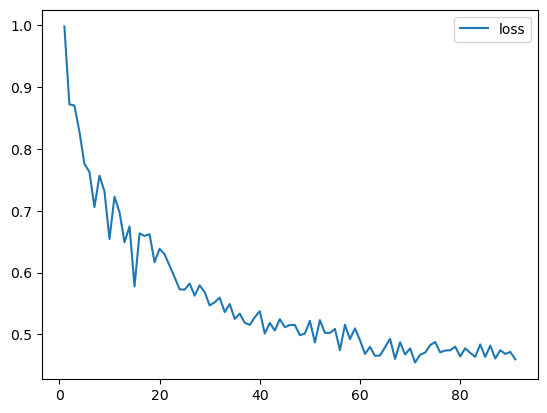

In [1512]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)
print (fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")


### Step 4: Save and export your model to a keras file, and name the file `student_loans.keras`.


In [1513]:
# Set the model's file path
file_path = Path("student_loans.keras")

# Export your model to a keras file
model.save(file_path)

---
## Predict Loan Repayment Success by Using your Neural Network Model

### Step 1: Reload your saved model.

In [1514]:
# Set the model's file path
file_path = Path("student_loans.keras")

# Load the model to a new object
lr_model = load_model(file_path)

### Step 2: Make predictions on the testing data and save the predictions to a DataFrame.

In [1515]:
# Make predictions with the test data
predictions = lr_model.predict(X_test_scaled,verbose=2)


# Display a sample of the predictions
display (predictions[:5])

10/10 - 0s - 58ms/epoch - 6ms/step


array([[0.926043  ],
       [0.10808307],
       [0.9745733 ],
       [0.7263677 ],
       [0.13727178]], dtype=float32)

In [1519]:
# Save the predictions to a DataFrame and round the predictions to binary results
predictions_df = pd.DataFrame(data=predictions, columns=['Predicted_Probability'])
# Round predictions to binary results (0 or 1) using 0.5 as the threshold
predictions_df['Predicted_Class'] = round(predictions_df['Predicted_Probability'])
predictions_df.head(20)

,Predicted_Probability,Predicted_Class
0,0.926043,1.0
1,0.108083,0.0
2,0.974573,1.0
3,0.726368,1.0
4,0.137272,0.0
5,0.466745,0.0
6,0.121588,0.0
7,0.331119,0.0
8,0.972006,1.0
9,0.887671,1.0


### Step 4: Display a classification report with the y test data and predictions

In [1517]:
# Print the classification report with the y test data and predictions
print(classification_report(y_test, predictions_df["Predicted_Class"].values))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       157
           1       0.77      0.79      0.78       163

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320



---
## Discuss creating a recommendation system for student loans

Briefly answer the following questions in the space provided:

1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.

2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.

3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.


As we had no Feature descriptions, basic assumtions have been made about the Feature meaning and the values. In the case of credit_ranking we are assuming that 1 is a loan in good standing and 0 is a loan in bad standing. Our model, based on the feature provided need to predict future loan risk so that we set an appopreate insterest rate to mate the risk based on the feature provided for past loan and the outcomes. 


**1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.**

Based on our model the following feature had the highes importance
financial_aid_score: 0.1022
total_loan_score: 0.0626
location_para meter: 0.0469
time_to_completion: 0.0448
stem_degree_score: 0.0261
study_major_code: 0.0240
payment_history: 0.0219


**2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.**



**3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.**



In [1518]:
original_accuracy = lr_model.evaluate(X_train_scaled, y_train)[1]
importances = []
feature_names = X_train.columns.tolist()

for i in range(X_train_scaled.shape[1]):
    # Shuffling one column at a time
    X_shuffled = X_train_scaled.copy()
    X_shuffled[:, i] = shuffle(X_shuffled[:, i])
    
    # Recalculate the accuracy after permutation
    shuffled_accuracy = model.evaluate(X_shuffled, y_train, verbose=0)[1]
    importances.append(original_accuracy - shuffled_accuracy)

# Display the importance of each feature
feature_importance = dict(zip(feature_names, importances))

# Sorting the feature_importance dictionary by importance values in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# Neatly printing each feature with its importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")

30/30 [==============================] - 0s 1ms/step - loss: 0.4263 - accuracy: 0.8050
financial_aid_score: 0.0970
total_loan_score: 0.0678
time_to_completion: 0.0261
study_major_code: 0.0219
location_parameter: 0.0209
payment_history: 0.0198
finance_workshop_score: 0.0136
alumni_success: 0.0104
stem_degree_score: 0.0052
cohort_ranking: 0.0052
gpa_ranking: 0.0021
